<a href="https://colab.research.google.com/github/farrelrassya/Handle-Missing-Value/blob/main/Handle_Missing_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [4]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [5]:
df['Potability'].value_counts(normalize=True)

0    0.60989
1    0.39011
Name: Potability, dtype: float64

In [6]:
df.drop('Potability', axis=1).skew()

ph                 0.025630
Hardness          -0.039342
Solids             0.621634
Chloramines       -0.012098
Sulfate           -0.035947
Conductivity       0.264490
Organic_carbon     0.025533
Trihalomethanes   -0.083031
Turbidity         -0.007817
dtype: float64

array([[<Axes: title={'center': 'ph'}>,
        <Axes: title={'center': 'Hardness'}>,
        <Axes: title={'center': 'Solids'}>],
       [<Axes: title={'center': 'Chloramines'}>,
        <Axes: title={'center': 'Sulfate'}>,
        <Axes: title={'center': 'Conductivity'}>],
       [<Axes: title={'center': 'Organic_carbon'}>,
        <Axes: title={'center': 'Trihalomethanes'}>,
        <Axes: title={'center': 'Turbidity'}>]], dtype=object)

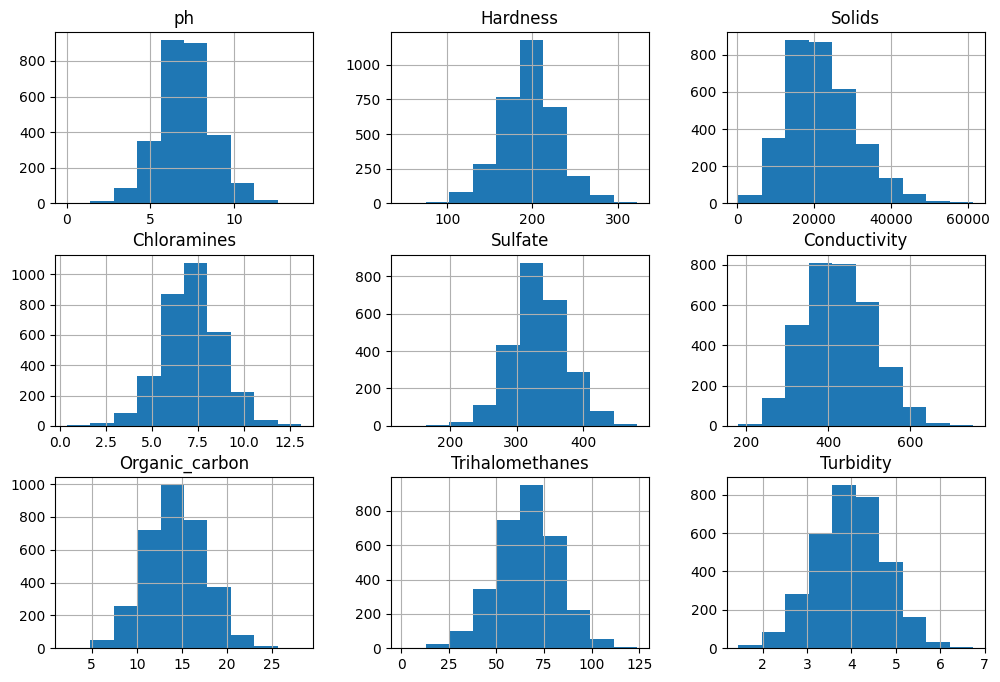

In [8]:
df.drop('Potability', axis=1).hist(figsize=(12,8))

In [9]:
fig = go.Figure(go.Heatmap(z=df.corr(), x=df.corr().columns.tolist(), y=df.corr().columns.tolist(), colorscale='agsunset'))
fig.show()

In [10]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

We have 3 features with the mssing values.

1. ph : 491
2. Sulfate : 781
3. Trihalomethanes : 162

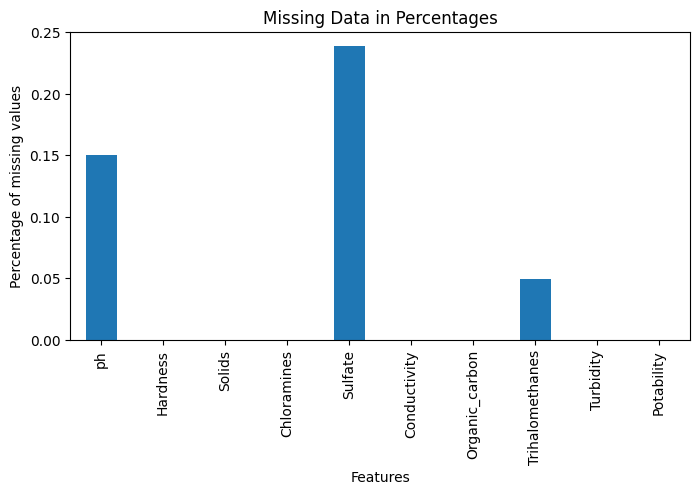

In [13]:

df.isnull().mean().plot.bar(figsize=(8,4))
plt.ylabel('Percentage of missing values')
plt.xlabel('Features')
plt.title('Missing Data in Percentages');

As we have seen,

1. ph : 14.98 %
2. Sulfate : 23.84 %
3. Trihalomethanes : 4.94 %

In [16]:
df = pd.read_csv('water_potability.csv')
X = df.drop('Potability', axis=1)
y = df['Potability']

#model = LinearDiscriminantAnalysis()

#cv = KFold(n_splits=3, shuffle=True, random_state=42)

#result = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

#print (f'Accuracy:: %{round(result.mean() * 100.0,3)}')

ValueError:
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
ValueError: Input X contains NaN.

In [19]:
df = pd.read_csv('water_potability.csv')
X = df.drop('Potability', axis=1)
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)
print(f'Size of the X_train: {X_train.shape[0]}')
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)
predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print (f'Accuracy:: {round(accuracy * 100.0,3)}')

Size of the X_train: 2293
Accuracy:: 65.209


In [20]:
print(f'Before dropping missing values, we have {df.shape[0]} instances')

df_dropped = df.dropna()
print(f'After dropping missing values, we have {df_dropped.shape[0]} instances')

# to see how mnay instances we have lost
print(f'We have lost {df.shape[0]-df_dropped.shape[0]} instances, which means % {round((df.shape[0]-df_dropped.shape[0])/ (float(df.shape[0])),2)*100} data we have lost')

Before dropping missing values, we have 3276 instances
After dropping missing values, we have 2011 instances
We have lost 1265 instances, which means % 39.0 data we have lost


In [21]:
df_dropped.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [22]:
X = df_dropped.drop('Potability', axis=1)
y = df_dropped['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)
print(f'Size of the X_train: {X_train.shape[0]}')
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)
predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print (f'Accuracy:: {round(accuracy * 100.0,3)}')

Size of the X_train: 1407
Accuracy:: 66.391


In [23]:
df = pd.read_csv('water_potability.csv')

X = df.drop('Potability', axis=1)
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [24]:
X_train.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
2985,NaN,188.445469,28791.614416,8.040356,382.009477,422.234861,10.575690,63.235365,3.228379
1073,7.203439,168.445358,22826.484697,6.283250,271.892045,437.370863,16.410654,64.505923,6.389161
3140,NaN,242.827588,29298.074262,5.853840,340.348645,463.115174,5.426650,NaN,3.522586
2643,6.056818,211.765886,4440.277357,9.507303,NaN,316.921776,17.766397,53.541191,3.358061
2174,9.581189,223.296216,28292.780318,5.665431,NaN,398.479317,11.350768,44.574120,3.929178


In [25]:
X_train.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,1939.000000,2293.000000,2293.000000,2293.000000,1731.000000,2293.000000,2293.000000,2180.000000,2293.000000
mean,7.096329,196.551035,22113.841276,7.114603,333.687852,426.699124,14.252296,66.450922,3.958445
std,1.590718,32.823436,8899.279189,1.575875,41.631895,81.657696,3.290887,16.288173,0.777717
min,0.000000,73.492234,728.750830,0.352000,129.000000,181.483754,4.371899,8.175876,1.492207
25%,6.096154,176.753500,15737.468938,6.105708,307.592458,367.854025,12.049131,55.746769,3.434538
50%,7.015333,197.331291,20988.429410,7.131704,332.349949,421.890083,14.171164,66.697224,3.941074
75%,8.074703,217.283262,27215.902742,8.107067,360.259558,481.853415,16.557177,77.578607,4.496627
max,14.000000,323.124000,61227.196008,13.043806,481.030642,753.342620,28.300000,124.000000,6.739000


In [26]:
X_train.skew()

ph                 0.044774
Hardness          -0.029392
Solids             0.669942
Chloramines       -0.033637
Sulfate           -0.044098
Conductivity       0.282242
Organic_carbon     0.015405
Trihalomethanes   -0.097298
Turbidity         -0.014962
dtype: float64

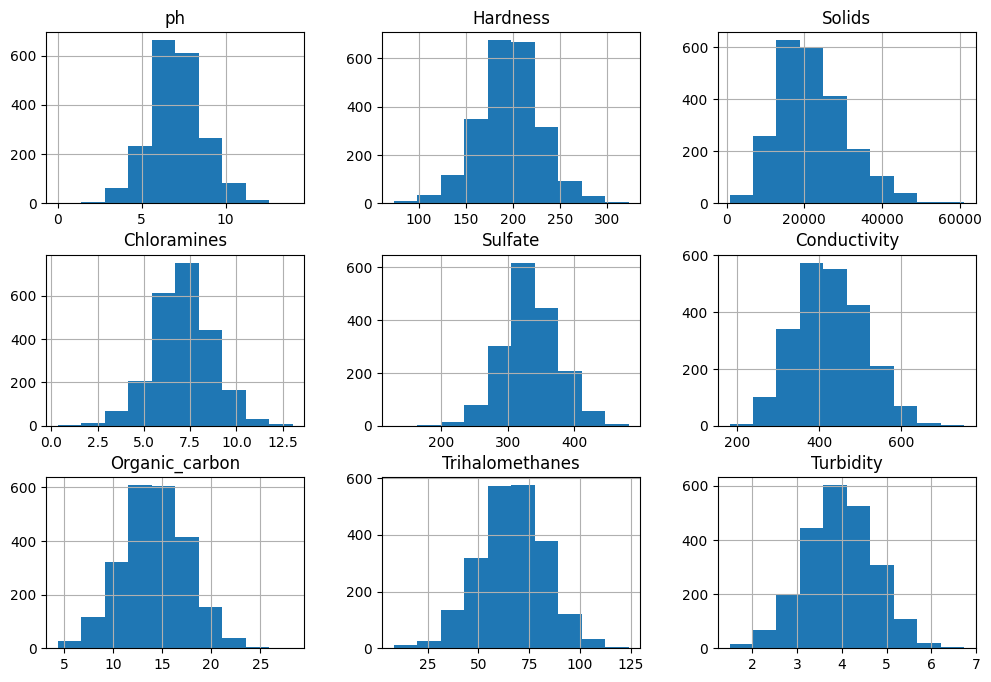

In [31]:
X_train.hist(figsize=(12,8));

In [32]:
X_train.isnull().mean()*100

ph                 15.438290
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            24.509376
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.928042
Turbidity           0.000000
dtype: float64

In [33]:

imputer = SimpleImputer(strategy='median') # median imputation ('mean' for mean and 'most_frequent' for mode imputations)

imputer.fit(X_train) # SimpleImputer() learns the median values from the train data

X_train = imputer.transform(X_train) # replace missing values with medians

X_test = imputer.transform(X_test) # replace missing values with medians

In [34]:
X_test=pd.DataFrame(X_test)
X_train= pd.DataFrame(X_train)
X_train.head()

,0,1,2,3,4,5,6,7,8
0,7.015333,188.445469,28791.614416,8.040356,382.009477,422.234861,10.575690,63.235365,3.228379
1,7.203439,168.445358,22826.484697,6.283250,271.892045,437.370863,16.410654,64.505923,6.389161
2,7.015333,242.827588,29298.074262,5.853840,340.348645,463.115174,5.426650,66.697224,3.522586
3,6.056818,211.765886,4440.277357,9.507303,332.349949,316.921776,17.766397,53.541191,3.358061
4,9.581189,223.296216,28292.780318,5.665431,332.349949,398.479317,11.350768,44.574120,3.929178


In [35]:
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(f'Size of the X_train: {X_train.shape[0]}')
accuracy = accuracy_score(y_test, predictions)
print (f'Accuracy:: {round(accuracy * 100.0,3)}')

Size of the X_train: 2293
Accuracy:: 65.107


In [36]:
df = pd.read_csv('water_potability.csv')

X = df.drop('Potability', axis=1)
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

imputer = SimpleImputer(strategy='constant', fill_value=9999) # arbitrary number imputation

imputer.fit(X_train) # SimpleImputer() learns the arbitrary number from the train data

X_train = imputer.transform(X_train) # replace missing values with arbitrary number

X_test = imputer.transform(X_test) # replace missing values with arbitrary number

In [37]:
X_test=pd.DataFrame(X_test)
X_train= pd.DataFrame(X_train)
X_train.head()

,0,1,2,3,4,5,6,7,8
0,9999.000000,188.445469,28791.614416,8.040356,382.009477,422.234861,10.575690,63.235365,3.228379
1,7.203439,168.445358,22826.484697,6.283250,271.892045,437.370863,16.410654,64.505923,6.389161
2,9999.000000,242.827588,29298.074262,5.853840,340.348645,463.115174,5.426650,9999.000000,3.522586
3,6.056818,211.765886,4440.277357,9.507303,9999.000000,316.921776,17.766397,53.541191,3.358061
4,9.581189,223.296216,28292.780318,5.665431,9999.000000,398.479317,11.350768,44.574120,3.929178


In [38]:
model = XGBClassifier(eval_metric='logloss')

model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(f'Size of the X_train: {X_train.shape[0]}')

accuracy = accuracy_score(y_test, predictions)
print (f'Accuracy:: {round(accuracy * 100.0,3)}')

Size of the X_train: 2293
Accuracy:: 64.802


In [41]:
df = pd.read_csv('water_potability.csv')

X = df.drop('Potability', axis=1)
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

imputer = SimpleImputer(strategy='median')

model = XGBClassifier(eval_metric='logloss')

pipeline = Pipeline(steps=[('imputer', imputer),('model', model)])

kfold = KFold(n_splits=10)
results = cross_val_score(model, X, y, cv=kfold)
print(f'Accuracy: Results Mean : %{round(results.mean()*100,3)}, Results Standard Deviation : {round(results.std()*100,3)}')

Accuracy: Results Mean : %58.82, Results Standard Deviation : 4.862
